# One Genre To Rule Them All... Domestically

We work for a ["Big Five"](https://en.wikipedia.org/wiki/Major_film_studio#Present) Hollywood movie studio, and we're deciding which movies to make this year.

But the guys upstairs don't want to go through the hassle of reading a bunch of scripts and sitting through a lot of meetings.

They just want to know which genre has the best chance of succeeding.

That's where we come in.

Our goal, should we choose to accept it, or be forced into it by powerful people who write our checks, is to analyze domestic movies by genre and determine which ones seem the most promising.

So let's get to it!

# The Domestic Market

We'll be using the movie data from the `Data_Cleaning` notebook. If you haven't had a chance to check it out, it's a collection of movies from [The Numbers](https://www.the-numbers.com/) and [Box Office Mojo](https://www.boxofficemojo.com/), two great sources of movie information. As a reminder, all monetary data has been converted to 2018 dollars to normalize them.

**We only care about the domestic box office for this study.** Yes, increasingly movies are being released worldwide, but we want to first judge a movie's chances in the domestic market. Who knows, maybe a worldwide analysis will take place at another time (or notebook... in this repository... nudge nudge).

Here are the steps we will use to accomplish our task:
- Decide which genres to consider in our analysis.
 
- Decide on a profitability measure.

- Whittle our dataset down to movies released by the Big Five. This is to control for factors like lack of budget or marketing affecting a movie's success. Sure, independent movies can succeed, but our bosses want to see how the genres performed with all the help of a studio behind them.

- Analyze the historical performance of the genres by decade. There might be some trends over time that would be useful to know.

- Analyze the historical performance of the genres by release week. Maybe certain genres perform better at certain times of year.

- Hopefully, give our bosses actionable insight!

# Deciding on Genres

According to [The Numbers](https://www.the-numbers.com/market/), the top six genres in terms of box office gross are:
- Adventure
- Action
- Drama
- Comedy
- Thriller/Suspense
- Horror

Our bosses like making money.

Sold.

# Is This Movie Profitable? 

The toughest question out there. Hollywood studios are notorious for phony accounting, cough cough [Harry Potter and the Order of the Phoenix](https://deadline.com/2010/07/studio-shame-even-harry-potter-pic-loses-money-because-of-warner-bros-phony-baloney-accounting-51886/).

Not our bosses though. They're great. Real... stand up... people.

Anyway, we must decide on a measure for how "successful" a movie is.

For simplicity, we will judge a movie as a success if it breaks even. The reason is that there are additional revenue streams for movies beyond the theaters. There's TV airings, rentals, DVD sales, merchandise, theme park rides, spinoff TV shows, sequels, etc. 


## How much do studios spend on movies?

Well, there's the production budget. We can either get that information or we can't.

Then there's the second biggest expense: marketing. But it's difficult to know the marketing costs of movies. An article at [How Stuff Works](https://entertainment.howstuffworks.com/movie-cost1.htm) cites that marketing spend is typically around 50% of the production budget of a movie.

## How much do studios make from the domestic box office?

According to this article on [The Week](https://theweek.com/articles/647394/when-buy-movie-ticket-where-does-that-money), movie studios only end up with about 50% of the total domestic box office. Movie theaters get the other half. 


## Profitability equation

Total spend = 150% production budget (adding 50% of production budget on top for marketing)

Total earnings = 0.5 * domestic box office

We want to know the point where Total spend = Total earnings, as this is the breakeven point.

Total spend = Total earnings

1.5 * production budget = 0.5 * domestic box office

**Domestic box office = 3 * Production budget**

So if a movie earns at least three times its production budget domestically, it is a winner!

# Curate our dataset

## Import libraries and settings

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

pd.options.display.max_rows = 400
pd.options.display.max_columns = 50

## Import data

In [5]:
data = pd.read_csv('cleaned_movie_data.csv', parse_dates=['release_date'], usecols=['title', 'distributor_mojo', 'domestic_adj', 'budget_adj',  'genres_mojo', 'release_year', 'release_week', 'release_date'])

# Only look at movies that made money domestically
data = data[data['domestic_adj'].notna() & data['domestic_adj'] > 0]

# For decade analysis
data['release_decade'] = data['release_year'].apply(lambda x: x // 10 * 10)

# For breakeven analysis
data['domestic_breakeven'] = data['domestic_adj'] >= 3 * data['budget_adj']

# Create columns for genres
# A movie can have multiple genres. If so, we will count them for all the genres its classified with.
data['action'] = data['genres_mojo'].str.contains('Action', na=False)
data['adventure'] = data['genres_mojo'].str.contains('Adventure', na=False) 
data['comedy'] = data['genres_mojo'].str.contains('Comedy', na=False)
data['drama'] = data['genres_mojo'].str.contains('Drama', na=False)
data['horror'] = data['genres_mojo'].str.contains('Horror', na=False)
data['thriller_suspense'] = data['genres_mojo'].str.contains('Thriller|Suspense', na=False, regex=True)

# Remove rows that don't contain one of our genres
data = data[data['action'] | data['adventure'] | data['comedy'] | data['drama'] | data['horror'] | data['thriller_suspense']]

# Create dataframes for the genres
action = data[data['genres_mojo'].str.contains('Action', na=False)]
adventure = data[data['genres_mojo'].str.contains('Adventure', na=False)] 
comedy = data[data['genres_mojo'].str.contains('Comedy', na=False)]
drama = data[data['genres_mojo'].str.contains('Drama', na=False)]
horror = data[data['genres_mojo'].str.contains('Horror', na=False)]
thriller_suspense = data[data['genres_mojo'].str.contains('Thriller|Suspense', na=False, regex=True)]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9241 entries, 2 to 19775
Data columns (total 16 columns):
title                 9241 non-null object
release_year          9241 non-null int64
distributor_mojo      9241 non-null object
genres_mojo           9241 non-null object
release_date          9241 non-null datetime64[ns]
domestic_adj          9241 non-null float64
budget_adj            3945 non-null float64
release_week          9241 non-null int64
release_decade        9241 non-null int64
domestic_breakeven    9241 non-null bool
action                9241 non-null bool
adventure             9241 non-null bool
comedy                9241 non-null bool
drama                 9241 non-null bool
horror                9241 non-null bool
thriller_suspense     9241 non-null bool
dtypes: bool(7), datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 785.1+ KB


## Organize By Distributors

The [Big Five](https://en.wikipedia.org/wiki/Major_film_studio#Past) studios we will use in our analysis are:
- Universal
- Paramount
- Warner Bros.
- Disney
- Sony

Studios have come and gone a lot historically. They get bought out by competitors, or go out of business. A lot of messy stuff.

To simplify, we will categorize a movie by its current studio owner. So for example, Disney [recently purchased](https://theweek.com/speedreads/780191/disney-buys-21st-century-fox-713-billion) 20th Century Fox. So we will categorize a 20th Century Fox movie as Disney.

In [7]:
data[data['budget_adj'].notna() & data['distributor_mojo'].notna()]['distributor_mojo'].value_counts()

Warner Bros.                        367
Universal                           364
Fox                                 309
Paramount                           283
Sony / Columbia                     272
Buena Vista                         234
New Line                            127
Miramax                             121
Fox Searchlight                     107
Lionsgate                           104
MGM                                 102
Sony Classics                        81
Sony / Screen Gems                   69
Focus Features                       64
Columbia                             53
Weinstein Company                    49
Warner Bros. (New Line)              49
IFC                                  47
Lions Gate                           44
United Artists                       44
DreamWorks                           42
Magnolia                             41
TriStar                              37
Roadside Attractions                 35
Open Road Films                      30


In [8]:
# Create a regex string to combine movies into their respective distributor
# https://en.wikipedia.org/wiki/Major_film_studio#Past
nbcuniversal = 'Universal|Focus Features|Focus World|Gramercy|Working Title|Big Idea|DreamWorks$|Illumination|Carnival|Mac Guff|United International'

print(data[data['distributor_mojo'].str.contains(nbcuniversal, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(nbcuniversal, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Universal                       553
Focus Features                  100
Gramercy                         46
DreamWorks                       43
Focus World                      13
Universal Home Entertainment      1
Name: distributor_mojo, dtype: int64
Sum: 756


In [9]:
viacom = 'Paramount|BET|Comedy Central|MTV|Nickelodeon|Bardel Entertainment|MTV Animation|Nickelodeon Animation Studio|Awesomeness|CMT|Melange|United International Pictures|VH1|Viacom 18 Motion Pictures'

print(data[data['distributor_mojo'].str.contains(viacom, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(viacom, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Paramount                 459
Paramount Classics         22
Paramount Vantage          20
Paramount (DreamWorks)     20
Paramount Insurge           2
Name: distributor_mojo, dtype: int64
Sum: 523


In [10]:
warnermedia = 'Warner Bros.|CNN Films|HBO|DC Films|New Line|Cartoon Network Studios|Wang Film Productions|Adult Swim Films|Castle Rock Entertainment|Cinemax|Flagship|Fullscreen|Hello Sunshine|Spyglass'

print(data[data['distributor_mojo'].str.contains(warnermedia, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(warnermedia, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Warner Bros.               621
New Line                   198
Warner Bros. (New Line)     51
Name: distributor_mojo, dtype: int64
Sum: 870


In [11]:
disney = 'Walt Disney|^Fox$|Fox Atomic|A&E|Disneynature|ESPN|Fox Searchlight|Hulu|National Geographic|VICE|Fox Family|Lucasfilm|Marvel|The Muppets Studio|UTV Motion Pictures|20th Century Fox Animation|Blue Sky Studios|Lucasfilm Animation|Marvel Animation|Pixar Animation Studios|Buena Vista|Disney|Dragonfly Film Productions|Fox Star Studios|Fox Studios Australia|Kudos Film|New Regency|Patagonik Film Group|Shine Group|Tiger Aspect Productions|Zero Day Fox'

print(data[data['distributor_mojo'].str.contains(disney, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(disney, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Fox                                  476
Buena Vista                          400
Fox Searchlight                      149
Disney                                 8
Fox Atomic                             4
National Geographic Entertainment      3
Name: distributor_mojo, dtype: int64
Sum: 1040


In [12]:
sony = 'Sony|Columbia|Affirm|Screen Gems|Stage 6|Ghost Corps|Funimation|Madhouse|Manga Entertainment UK|TriStar|Destination Films|Left Bank Pictures|Triumph Films'

print(data[data['distributor_mojo'].str.contains(sony, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(sony, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Sony / Columbia            348
Sony Classics              182
Columbia                   155
TriStar                    107
Sony / Screen Gems          75
Sony (Revolution)           35
Sony / AFFIRM Films          2
Sony Pictures Home Ent.      1
Sony BMG                     1
Name: distributor_mojo, dtype: int64
Sum: 906


In [13]:
data['universal'] = data['distributor_mojo'].str.contains(nbcuniversal, na=False, regex=True)
data['paramount'] = data['distributor_mojo'].str.contains(viacom, na=False, regex=True)
data['warner'] = data['distributor_mojo'].str.contains(warnermedia, na=False, regex=True)
data['disney'] = data['distributor_mojo'].str.contains(disney, na=False, regex=True)
data['sony'] = data['distributor_mojo'].str.contains(sony, na=False, regex=True)
data['distributor'] = np.nan

In [14]:
data.loc[data['universal'], 'distributor'] = 'Universal'
data.loc[data['paramount'], 'distributor'] = 'Paramount'
data.loc[data['warner'], 'distributor'] = 'Warner'
data.loc[data['disney'], 'distributor'] = 'Disney'
data.loc[data['sony'], 'distributor'] = 'Sony'

In [15]:
# We only want to keep rows that have one of the Big Five
data = data[data['distributor'].notna()]

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4095 entries, 14 to 19775
Data columns (total 22 columns):
title                 4095 non-null object
release_year          4095 non-null int64
distributor_mojo      4095 non-null object
genres_mojo           4095 non-null object
release_date          4095 non-null datetime64[ns]
domestic_adj          4095 non-null float64
budget_adj            2556 non-null float64
release_week          4095 non-null int64
release_decade        4095 non-null int64
domestic_breakeven    4095 non-null bool
action                4095 non-null bool
adventure             4095 non-null bool
comedy                4095 non-null bool
drama                 4095 non-null bool
horror                4095 non-null bool
thriller_suspense     4095 non-null bool
universal             4095 non-null bool
paramount             4095 non-null bool
warner                4095 non-null bool
disney                4095 non-null bool
sony                  4095 non-null bool
distr

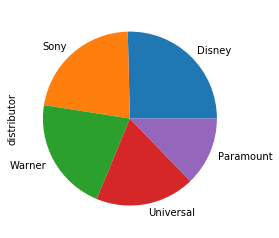

In [16]:
data['distributor'].value_counts().plot(kind='pie');

## Summary

Our filtered dataset now has 4,095 entries. 

The only missing information in our dataframe is in the `budget_adj` column, which is a movie's production budget.

We will just ignore the missing entries when we need the production budget information. 

The reason we won't fill in missing budgets with a genre's mean budget is that many movies have multiple genres. This would open the door to bad estimates of a movie's budget. For example, if we have an action comedy movie, do we give it the mean budget of action or comedy? The average of both genres? 

We will reassess this decision later if it seems like the lack of budget information is a problem.

In [17]:
data[data['budget_adj'].isna()]['genres_mojo'].value_counts()

Comedy                290
Drama                 196
Romantic Comedy       112
Comedy / Drama         81
Thriller               70
Horror                 65
Family Comedy          62
Family Adventure       54
Action Comedy          47
Action                 45
Drama / Thriller       37
Crime Drama            33
Music Drama            32
Fantasy Comedy         27
Crime Comedy           27
Sports Drama           26
Period Drama           26
Sports Comedy          24
Action Thriller        21
Horror Comedy          18
Period Comedy          17
Sci-Fi Adventure       16
Crime Thriller         16
Action Drama           14
Horror Thriller        14
Romantic Thriller      14
War Drama              14
Sci-Fi Comedy          13
Sci-Fi Horror          12
Action / Crime         12
Period Adventure       11
Adventure              10
Sci-Fi Action           9
Fantasy Drama           9
Comedy Thriller         9
Sci-Fi Thriller         8
Foreign / Action        7
Action / Adventure      7
Historical D

# Create Graphing Helper Function and Reusable Lists

In [18]:
# Tailored from matplotlib documentation
# https://matplotlib.org/examples/api/barchart_demo.html
def autolabel(axis, num_decimals=0, counts=None):
    """
    Attach a text label above each bar displaying its height.
    If sent a list of counts, display those instead.
    """
    for i, val in enumerate(axis.patches):
        if counts is not None:
            height = counts[i]
        else:
            height = round(val.get_height(), num_decimals) if num_decimals > 0 else int(val.get_height())
        
        # We don't want to display zeros on our bar plots
        if height == 0:
            continue
            
        axis.text(val.get_x() + val.get_width()/2, val.get_height()*1.05, '{}'.format(height), ha='center', va='bottom', fontsize=20)

In [35]:
# Create lists of useful information for graphing
genres = ['action', 'adventure', 'comedy', 'drama', 'horror', 'thriller_suspense']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

# Create a summary statistics dataframe separated by genre to make graphing easier
# The columns are:
# Number of movies
# Average gross
# All-time gross
# Average budget
# All-time budget
# Dollar earned for dollar spent (including marketing -- adjusted budget is 1.5 times original budget)

aggregation_stats_per_genre = {
    'num_movies': [data[genre].sum() for genre in genres],
    'avg_gross': [round(data[data[genre]]['domestic_adj'].mean() / 1000000, 1) for genre in genres],
    'all_time_gross': [round(data[data[genre]]['domestic_adj'].sum() / 1000000, 1) for genre in genres],
    'avg_budget': [round(data[data[genre]]['budget_adj'].mean() / 1000000, 1) for genre in genres],
    'all_time_budget': [round(data[data[genre]]['budget_adj'].sum() / 1000000, 1) for genre in genres],
    'dollars_earned_for_dollars_spent': [round((data[data[genre]]['domestic_adj'].sum() / 2000000) / (1.5 * data[data[genre]]['budget_adj'].sum() / 1000000), 1) for genre in genres]
}

# Bird's Eye View Of The Data

We created a few custom functions for adding numerical labels to our bar plots.

We will do some exploratory data analysis to get a sense of our dataset's breakdown by genre.

In [36]:
summary = pd.DataFrame(aggregation_stats_per_genre, index=genres)
summary

,num_movies,avg_gross,all_time_gross,avg_budget,all_time_budget,dollars_earned_for_dollars_spent
action,669,116.6,77996.4,101.0,49880.2,0.5
adventure,366,151.0,55281.9,121.5,31717.2,0.6
comedy,1737,65.6,114009.4,45.2,45185.0,0.8
drama,1166,50.3,58622.1,40.5,28051.9,0.7
horror,378,76.9,29052.2,43.6,11376.2,0.9
thriller_suspense,558,65.3,36418.6,55.8,20600.7,0.6


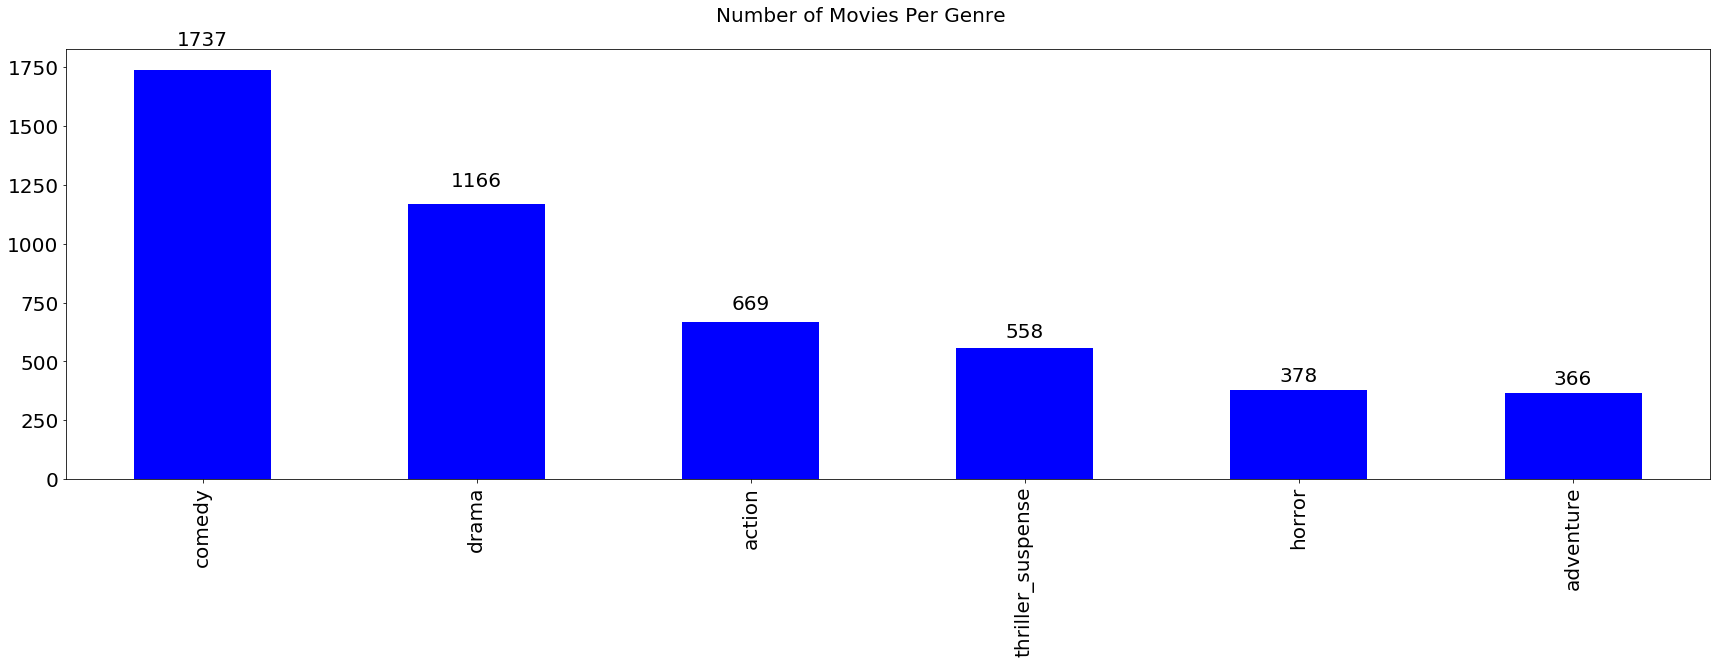

In [37]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Number of Movies Per Genre', fontsize=20, y=1.02)

summary.sort_values('num_movies', ascending=False, inplace=True)

summary.plot(y='num_movies', kind='bar', color=colors[0], ax=axis, legend=False)
axis.set_ylabel('')
axis.set_xlabel('')
axis.tick_params(labelsize=20)
autolabel(axis)

plt.tight_layout()

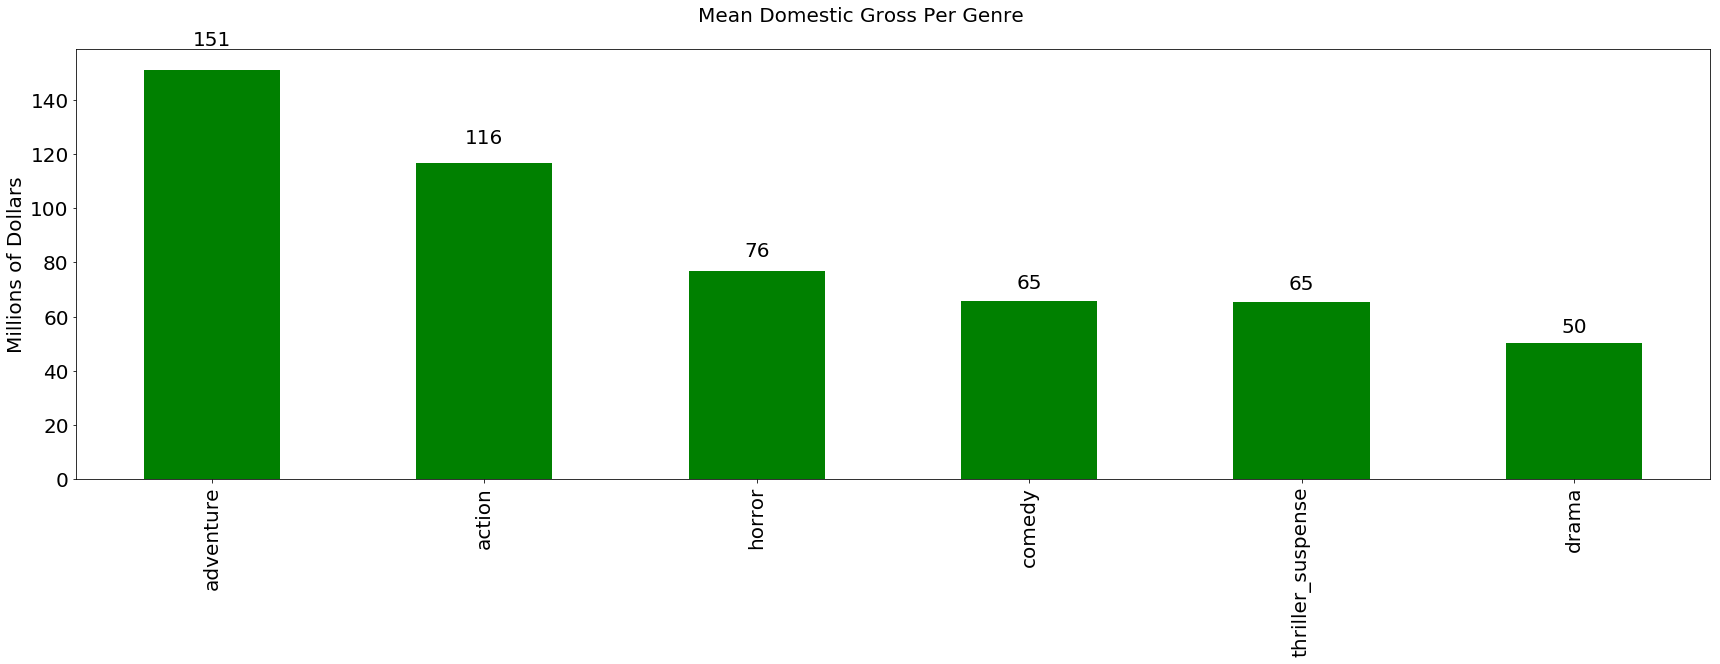

In [38]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Mean Domestic Gross Per Genre', fontsize=20, y=1.02)

summary.sort_values('avg_gross', ascending=False, inplace=True)

summary.plot(y='avg_gross', kind='bar', ax=axis, color=colors[1], legend=False)
axis.set_ylabel('Millions of Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
autolabel(axis)

plt.tight_layout()

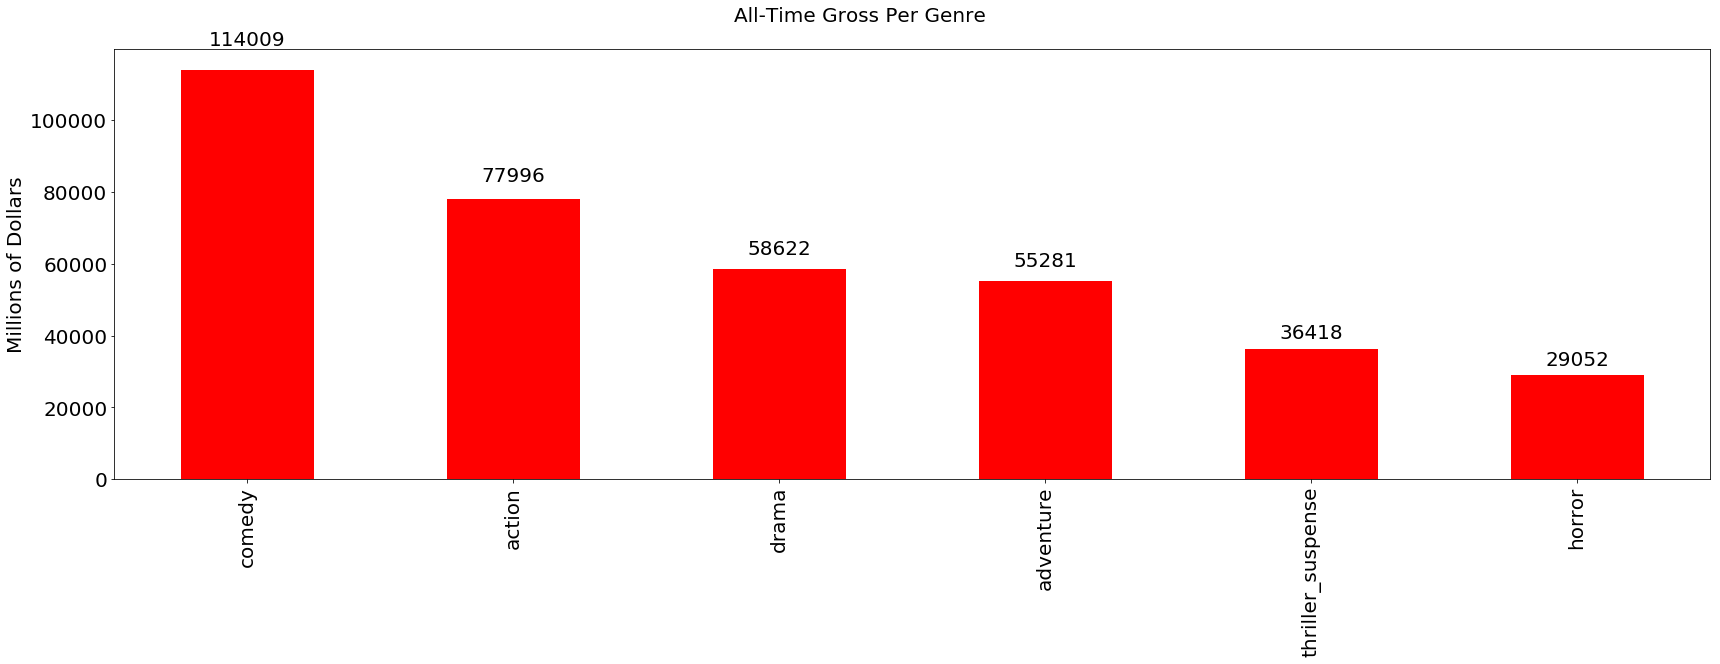

In [39]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('All-Time Gross Per Genre', fontsize=20, y=1.02)

summary.sort_values('all_time_gross', ascending=False, inplace=True)

summary.plot(y='all_time_gross', kind='bar', ax=axis, color=colors[2], legend=False)
axis.set_ylabel('Millions of Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
autolabel(axis)

plt.tight_layout()

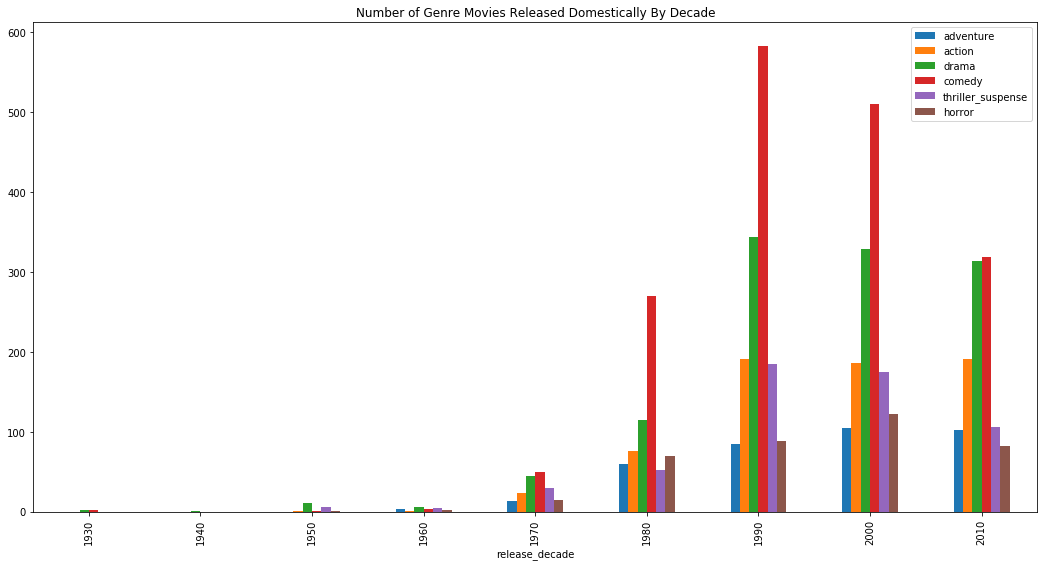

In [40]:
figure, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(18,9))

# Since we are dealing with boolean columns, we must use 'sum' to get the total counts
data.groupby('release_decade').sum().plot.bar(y=['adventure', 'action', 'drama', 'comedy', 'thriller_suspense', 'horror'], ax=ax1, title='Number of Genre Movies Released Domestically By Decade')

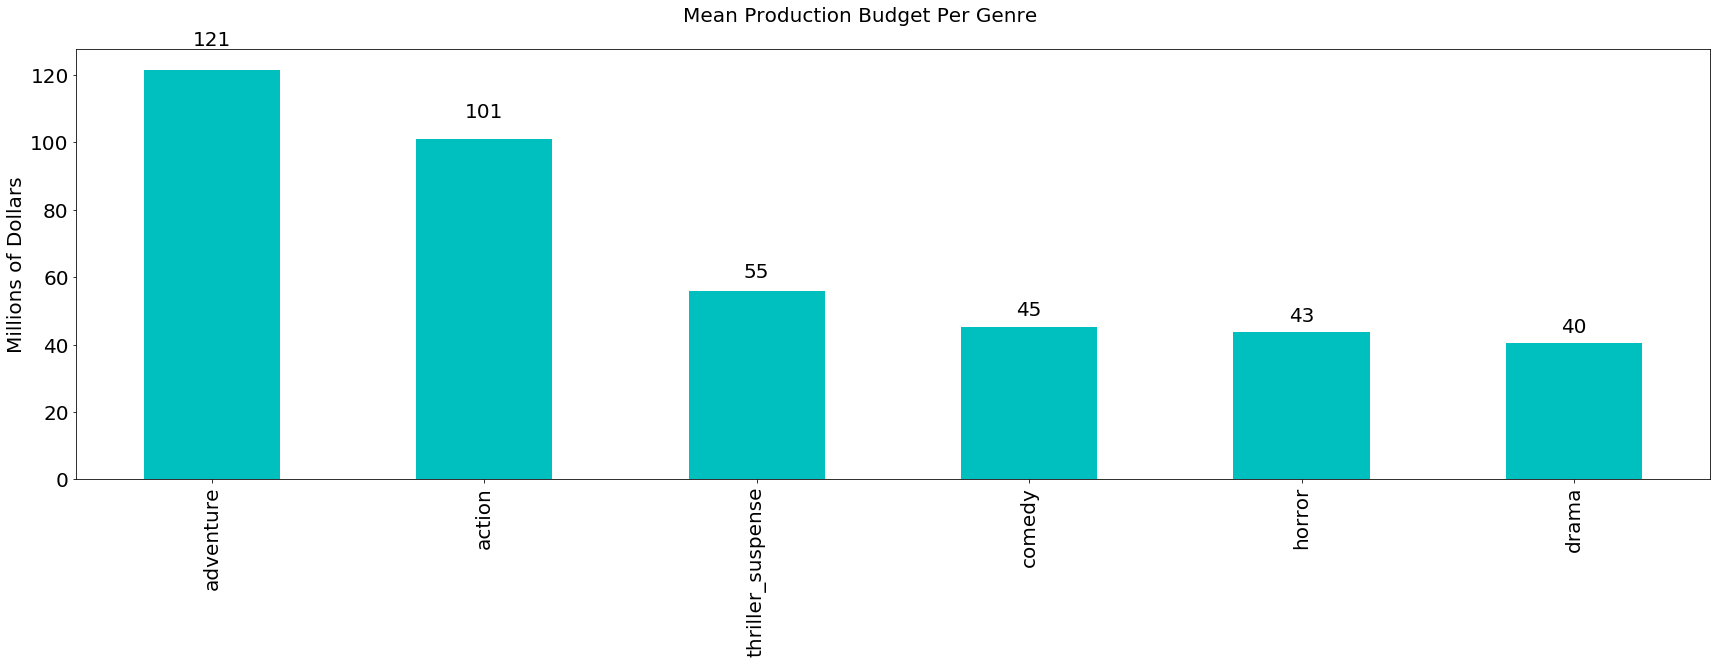

In [41]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Mean Production Budget Per Genre', fontsize=20, y=1.02)

summary.sort_values('avg_budget', ascending=False, inplace=True)

summary.plot(y='avg_budget', kind='bar', ax=axis, color=colors[3], legend=False)
axis.set_ylabel('Millions of Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
autolabel(axis)

plt.tight_layout()

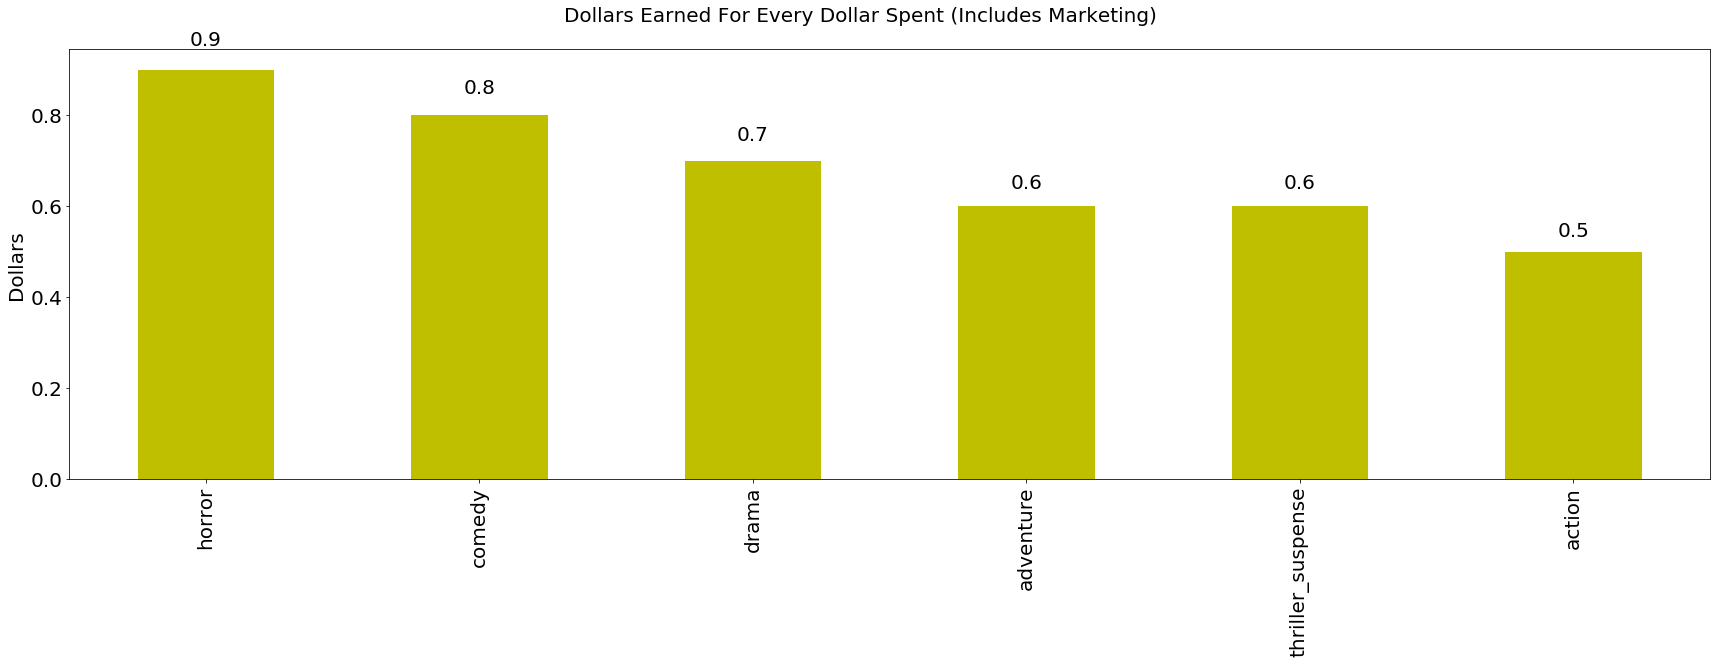

In [42]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Dollars Earned For Every Dollar Spent (Includes Marketing)', fontsize=20, y=1.02)

summary.sort_values('dollars_earned_for_dollars_spent', ascending=False, inplace=True)

summary.plot(y='dollars_earned_for_dollars_spent', kind='bar', ax=axis, color=colors[5], legend=False)
axis.set_ylabel('Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
autolabel(axis, num_decimals=1)

plt.tight_layout()

# Initial Thoughts

**Number of movies**
  - `Comedy` and `Drama` are historically the most produced genres by big movie studios by a healthy margin
  - That trend continues in modern times. The last five decades have seen `Comedy` as the most produced genre and `Drama` as the second-highest
  
  
**Average domestic gross**
  - `Adventure` and `Action` historically gross the highest average amount per movie
  - Perhaps surprisingly, `Horror` is in third place


**All-Time Gross Per Genre**
  - In aggregate, `Comedy` and `Action` movies have grossed the most money domestically
  - `Comedy` is ahead of the next highest genre by over \\$36 billion dollars
  
  
**Average production budget**
  - `Adventure` and `Action` have by far the largest average production budget. This makes sense, as those movies tend to require more setpieces and CGI than other genres
  - `Comedy`, `Horror`, and `Drama` all have very similar, low average production budgets 
  
**Dollar earned for every dollar spent**
  - We count dollars earned as half the total domestic gross
  - In aggregate, `Horror` and `Comedy` are the best return on investment on a per dollar spent basis.
  - `Drama` is in third place.
  - No genre averages breakeven in the domestic market alone

**Summing up**

`Comedy` overall makes the most money, but also has a much lower per-movie-average than `Action` and `Adventure.` But `Action` and `Adventure` cost more to make.

The best return for every dollar spent in aggregate come from `Comedy` and `Horror`.

There are a couple strategies our bosses can consider:

1) Go for making relatively more movies that have a lower pricetag and are "safer." These would gross less money per movie, but offer a better average return on investment. This category is `Comedy`, `Horror`, and `Drama`.

2) Go for making relatively fewer movies with a higher pricetag. These would offer higher returns on winners, but also lose big on losers. These would be `Action` and `Adventure`.

Let's look at each genre's performance by decade to see if there have been changes we can latch onto.

# Performance By Decade

## All Decades

### Domestic Gross

In [ ]:
# Create variables for first_axes, secondary_axes, and counter variables 
ax1, ax2, ax3, ax4, ax5, ax6 = 'abcdef'
first_axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

ax1_1, ax2_1, ax3_1, ax4_1, ax5_1, ax6_1 = 'abcdef'
second_axes_list = [ax1_1, ax2_1, ax3_1, ax4_1, ax5_1, ax6_1]

# Counters to keep track of iteration
counters = [0, 1, 2, 3, 4, 5]

for genre, first_axis, second_axis, color, count in zip(genres, first_axes_list, second_axes_list, colors, counters):
        figure, first_axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 5))
        second_axis = figure.add_axes()

        # Only write the title once
        if count == 0:
            figure.suptitle('Mean Domestic Gross By Genre And Decade', fontsize=20, y=1.02)

        grp = (data[data[genre]].groupby('release_decade').mean() / 1000000)['domestic_adj'].copy()
        grp_counts = data[data[genre]].groupby('release_decade')['domestic_adj'].count().copy()
    
        # If the series is missing a decade, add it as an index and set the value to zero
        for decade in range(1910, 2020, 10):
            if decade not in grp.index:
                grp.loc[decade] = 0
                grp_counts.loc[decade] = 0

        # Sort the series by its index to have the decades in chronological order                
        grp.sort_index(ascending=True, inplace=True)
        grp_counts.sort_index(ascending=True, inplace=True)
        
        # Set up y-axis    
        first_axis = grp.plot(kind='bar', xticks=range(1910, 2020, 10), linewidth=3, color=color)
        first_axis.set_ylabel('Domestic Gross In Millions', fontsize=12)
        first_axis.set_ylim(0,350)
        first_axis.legend([genre], loc=2, fontsize=15)
        
        # Set up second y-axis
        second_axis = first_axis.twinx()
        second_axis.plot(first_axis.get_xticks(), grp_counts.values, linewidth=3, color='k')
        second_axis.set_ylabel('Number of Movies', fontsize=12)
        second_axis.set_ylim(0,600)
        second_axis.legend(['counts'], loc=1, fontsize=15)
        
        # Only show graphs when on the last one
        if count == len(counters) - 1:
            plt.tight_layout()

Key Takeaways:
- The 1970s seems like the best decade for the average movie in terms of domestic box office gross. 
- The average domestic return of movies in all genres has declined significantly in the past four decades
- This is probably due to the sheer number of movies releasd these days. A few big winners can't boost the average for the many losers.

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Mean Domestic Gross By Genre And Decade', fontsize=20, y=1.02)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    # We must replace missing decades with zeroes to have the bar plots xticks line up
    
    # Create a series with decades as indexes and domestic gross as values
    grp = (data[data[genre]].groupby('release_decade').mean() / 1000000)['domestic_adj'].copy()
    grp_counts = data[data[genre]].groupby('release_decade')['domestic_adj'].count().copy()
    
    # If the series is missing a decade, add it as an index and set the value to zero
    for decade in range(1910, 2020, 10):
        if decade not in grp.index:
            grp.loc[decade] = 0
            grp_counts.loc[decade] = 0
    
    # Sort the series by its index to have the decades in chronological order                
    grp.sort_index(ascending=True, inplace=True)
    grp_counts.sort_index(ascending=True, inplace=True)
        
    grp.plot(kind='bar', xticks=range(1910, 2020, 10), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Domestic Gross In Millions', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the count of each genre made per decade above each bar
    autolabel(axis, counts=grp_counts.values)

plt.tight_layout() 

### Production Budget

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Mean Production Budget By Genre And Release Week', fontsize=20, y=1.02)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    # We must replace missing decades with zeroes to have the bar plots xticks line up
    
    # Create a series with decades as indexes and domestic gross as values
    grp = (data[data[genre]].groupby('release_decade').mean() / 1000000)['budget_adj'].copy()
    
    # If the series is missing a decade, add it as an index and set the value to zero
    for decade in range(1910, 2020, 10):
        if decade not in grp.index:
            grp.loc[decade] = 0
    
    # Sort the series by its index to have the decades in chronological order                
    grp.sort_index(ascending=True, inplace=True)
        
    grp.plot(kind='bar', xticks=range(1910, 2020, 10), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Production Budget In Millions', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    autolabel(axis)

plt.tight_layout() 

Key Takeaways:
- Production budgets for Action and Adventure have been increasing since the 1980s
- Production budgets for all other genres have declined since the 1980s
- This is probably due to the heavy use of expensive CGI in Action and Adventure movies, which has only increased over time. Meanwhile, technological advancements have decreased the overall cost of producing movies in general.

### Domestic Breakeven Percentage

In [ ]:
# Create new column on summary dataframe to hold the most recent breakeven percentage by genre
summary['2010s_breakeven_percent'] = np.nan

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Domestic Breakeven Percentage By Decade', fontsize=20, y=1.02)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    # Create two series with decades as indexes and count and sum as values
    grp_count = data[data[genre]].groupby('release_decade')['domestic_breakeven'].count().copy()
    grp_sum = data[data[genre]].groupby('release_decade')['domestic_breakeven'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for decade in range(1910, 2020, 10):
        if decade not in grp_count.index:
            grp_count.loc[decade] = 0
            grp_sum.loc[decade] = 0

    # Sort the series by their index to have the decades in chronological order                
    grp_count.sort_index(ascending=True, inplace=True)
    grp_sum.sort_index(ascending=True, inplace=True)
    
    summary.loc[genre, ['2010s_breakeven_percent']] = round((grp_sum / grp_count * 100).loc[2010],1)

    (grp_sum / grp_count * 100).plot(kind='bar', xticks=range(2010, 2019, 1), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Percentage', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the count of how many movies breakeven above each bar
    autolabel(axis, counts=grp_count.values)
    
plt.tight_layout() 

In [ ]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('2010s Breakeven Percentage By Genre', fontsize=20, y=1.02)

summary.sort_values('2010s_breakeven_percent', ascending=False, inplace=True)

summary.plot(y='2010s_breakeven_percent', kind='bar', ax=axis, color=colors[0], legend=False)
axis.set_ylabel('Percentage', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
autolabel(axis, num_decimals=1)

plt.tight_layout()

### Quick Thoughts

**Movies are more risky now**
  - From the 1960s to 1990s, regardless of genre, there was an overall decrease in a movie's probability of breaking even
  - Such a decrease went alongside a huge increase in the numbers of movies released overall
  - The market might have gotten oversaturated, at which point the same amount of consumer dollars could not support the increase in movies
  
  - From the 2000s to the 2010s, most genres have had their output reduced
  - This reduction in output coincides with an increase in a genre's probability of success
  - It could be that a huge contributor to a movie's ultimate success is just the number of movies it has to compete with

**Safest current genres**
  - `Horror` is by far the safest domestic release genre
  - `Thriller/Suspense`, and `Comedy` are the next safest from a breakeven perspective
  - `Action` and `Adventure` have very little chance of breaking even in just the domestic market

### Only Looking At Movies With A Production Budget

In [ ]:
has_budget = data[data['budget_adj'].notna()].copy()
has_budget.info()

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Dollars Earned For Every Dollar Spent By Decade (Includes Marketing)\n(Percentages Labeled)', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    # Create two series with decades as indexes and count and sum as values
    grp_gross_count = has_budget[has_budget[genre]].groupby('release_decade')['domestic_adj'].count().copy()
    grp_gross_sum = has_budget[has_budget[genre]].groupby('release_decade')['domestic_adj'].sum().copy()
    
    grp_budget_count = has_budget[has_budget[genre]].groupby('release_decade')['budget_adj'].count().copy()
    grp_budget_sum = has_budget[has_budget[genre]].groupby('release_decade')['budget_adj'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for decade in range(1910, 2020, 10):
        if decade not in grp_gross_count.index:
            grp_gross_count.loc[decade] = 0
            grp_gross_sum.loc[decade] = 0
        
        if decade not in grp_budget_count.index:
            grp_budget_count.loc[decade] = 0
            grp_budget_sum.loc[decade] = 1

    # Sort the series by their index to have the decades in chronological order                
    grp_gross_count.sort_index(ascending=True, inplace=True)
    grp_gross_sum.sort_index(ascending=True, inplace=True)
    grp_budget_count.sort_index(ascending=True, inplace=True)
    grp_budget_sum.sort_index(ascending=True, inplace=True)
    
    dollars_earned_to_dollars_spent = round((grp_gross_sum / (1.5 * grp_budget_sum)), 1)
            
    dollars_earned_to_dollars_spent.plot(kind='bar', xticks=range(1910, 2020, 10), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Dollars', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the percentage of how many movies breakeven above each bar
    autolabel(axis, num_decimals=1)
    
plt.tight_layout() 

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Dollars Earned For Every Dollar Spent By Decade (Includes Marketing)\n(Counts Labeled)', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    # Create two series with decades as indexes and count and sum as values
    grp_gross_count = has_budget[has_budget[genre]].groupby('release_decade')['domestic_adj'].count().copy()
    grp_gross_sum = has_budget[has_budget[genre]].groupby('release_decade')['domestic_adj'].sum().copy()
    
    grp_budget_count = has_budget[has_budget[genre]].groupby('release_decade')['budget_adj'].count().copy()
    grp_budget_sum = has_budget[has_budget[genre]].groupby('release_decade')['budget_adj'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for decade in range(1910, 2020, 10):
        if decade not in grp_gross_count.index:
            grp_gross_count.loc[decade] = 0
            grp_gross_sum.loc[decade] = 0
        
        if decade not in grp_budget_count.index:
            grp_budget_count.loc[decade] = 0
            grp_budget_sum.loc[decade] = 1

    # Sort the series by their index to have the decades in chronological order                
    grp_gross_count.sort_index(ascending=True, inplace=True)
    grp_gross_sum.sort_index(ascending=True, inplace=True)
    grp_budget_count.sort_index(ascending=True, inplace=True)
    grp_budget_sum.sort_index(ascending=True, inplace=True)
    
    dollars_earned_to_dollars_spent = round((grp_gross_sum / (1.5 * grp_budget_sum)), 1)
            
    dollars_earned_to_dollars_spent.plot(kind='bar', xticks=range(1910, 2020, 10), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Dollars', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the count of how many movies breakeven above each bar
    autolabel(axis, counts=grp_gross_count.values)
    
plt.tight_layout() 

### Quick Takeaways

**Recent data is more reliable**
  - We don't have many movies before the 1970s, so drawing conclusions there seems risky. For example, the huge spike in `Horror` in 1950 is due to a single movie.
  - We should be able to trust the more recent data as there are far more movies available.
  
**Last three decades**
  - `Horror`, `Comedy`, and `Drama` are the best dollar for dollar movies.

## Current Decade

In [ ]:
current = data[data['release_year'] >= 2010].copy()

figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Percentage of Movies That Breakeven This Decade\n (Counts are labeled)', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    # Create two series with decades as indexes and count and sum as values
    grp_count = current[current[genre]].groupby('release_year')['domestic_breakeven'].count().copy()
    grp_sum = current[current[genre]].groupby('release_year')['domestic_breakeven'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for year in range(2010, 2019, 1):
        if year not in grp_count.index:
            grp_count.loc[year] = 0
            grp_sum.loc[year] = 0

    # Sort the series by their index to have the decades in chronological order                
    grp_count.sort_index(ascending=True, inplace=True)
    grp_sum.sort_index(ascending=True, inplace=True)

    (grp_sum / grp_count * 100).plot(kind='bar', xticks=range(2010, 2019, 1), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Percentage', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the count of how many movies breakeven above each bar
    autolabel(axis, counts=grp_count.values)
    
plt.tight_layout() 

### Quick Thoughts

**Year by year takeaways**
  - There is a great deal of variety in box office results on a year by year basis
  - For the past decade, the strongest performing genre from a breakeven perspective appears to be `Horror`
  - `Thriller/Suspense` is the next best option  

In [ ]:
current_with_budget = data[(data['release_year'] >= 2010) & (data['budget_adj'].notna())].copy()
current_with_budget.info()

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Dollars Earned For Every Dollar Spent This Decade (Includes Marketing)\n(Percentages Labeled)', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    # Create two series with decades as indexes and count and sum as values
    grp_gross_count = current_with_budget[current_with_budget[genre]].groupby('release_year')['domestic_adj'].count().copy()
    grp_gross_sum = current_with_budget[current_with_budget[genre]].groupby('release_year')['domestic_adj'].sum().copy()
    
    grp_budget_count = current_with_budget[current_with_budget[genre]].groupby('release_year')['budget_adj'].count().copy()
    grp_budget_sum = current_with_budget[current_with_budget[genre]].groupby('release_year')['budget_adj'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for year in range(2010, 2019, 1):
        if year not in grp_gross_count.index:
            grp_gross_count.loc[year] = 0
            grp_gross_sum.loc[year] = 0
        
        if year not in grp_budget_count.index:
            grp_budget_count.loc[year] = 0
            grp_budget_sum.loc[year] = 1

    # Sort the series by their index to have the decades in chronological order                
    grp_gross_count.sort_index(ascending=True, inplace=True)
    grp_gross_sum.sort_index(ascending=True, inplace=True)
    grp_budget_count.sort_index(ascending=True, inplace=True)
    grp_budget_sum.sort_index(ascending=True, inplace=True)
    
    dollars_earned_to_dollars_spent = round((grp_gross_sum / (1.5 * grp_budget_sum)), 1)
            
    dollars_earned_to_dollars_spent.plot(kind='bar', xticks=range(2010, 2019, 1), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Dollars', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the percentage of how many movies breakeven above each bar
    autolabel(axis, num_decimals=1)
    
plt.tight_layout() 

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Dollars Earned For Every Dollar Spent This Decade (Includes Marketing)\n(Counts Labeled)', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    # Create two series with decades as indexes and count and sum as values
    grp_gross_count = current_with_budget[current_with_budget[genre]].groupby('release_year')['domestic_adj'].count().copy()
    grp_gross_sum = current_with_budget[current_with_budget[genre]].groupby('release_year')['domestic_adj'].sum().copy()
    
    grp_budget_count = current_with_budget[current_with_budget[genre]].groupby('release_year')['budget_adj'].count().copy()
    grp_budget_sum = current_with_budget[current_with_budget[genre]].groupby('release_year')['budget_adj'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for year in range(2010, 2019, 1):
        if year not in grp_gross_count.index:
            grp_gross_count.loc[year] = 0
            grp_gross_sum.loc[year] = 0
        
        if year not in grp_budget_count.index:
            grp_budget_count.loc[year] = 0
            grp_budget_sum.loc[year] = 1

    # Sort the series by their index to have the decades in chronological order                
    grp_gross_count.sort_index(ascending=True, inplace=True)
    grp_gross_sum.sort_index(ascending=True, inplace=True)
    grp_budget_count.sort_index(ascending=True, inplace=True)
    grp_budget_sum.sort_index(ascending=True, inplace=True)
    
    dollars_earned_to_dollars_spent = round((grp_gross_sum / (1.5 * grp_budget_sum)), 1)
            
    dollars_earned_to_dollars_spent.plot(kind='bar', xticks=range(2010, 2019, 1), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Dollars', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the count of how many movies breakeven above each bar
    #utolabel(axis, to_round=False)
    autolabel(axis, counts=grp_gross_count.values)
    
plt.tight_layout() 

### Quick Takeaways

For the past decade, `Horror` seems to trump the other genres in terms of the dollar earned per dollar risked metric. And yet, it has some of the lowest numbers of movies produced. Perhaps this is because `Horror` is more of a niche genre, frequently produced by independent studios.

What is surprising is how low the dollar for dollar numbers are. Movies (at least domestically) aren't slam dunks by any means. If not for the worldwide market and ancillary revenue streams, movie studios should probably put their money elsewhere.

# Analyze By Release Week

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Mean Domestic Gross By Genre And Release Week', fontsize=20, y=1.02)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    grp = data[data[genre]].groupby('release_week').mean() / 1000000
    grp.plot(kind='bar', y='domestic_adj', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Domestic Gross In Millions', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)

plt.tight_layout() 

Key Takeaways:

**Summer release**
  - `Action` and `Adventure` benefit the most from being a Summer release, although all genres have a bump there. 
  
**Winter holidays release**
  - `Action`, `Adventure`, and `Horror` seem to have the biggest bumps here.

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Mean Production Budget By Genre And Release Week', fontsize=20, y=1.02)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    grp = data[data[genre]].groupby('release_week').mean() / 1000000
    grp.plot(kind='bar', y='budget_adj', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Budget In Millions', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)

plt.tight_layout() 

Key Takeaways:
- `Action` and `Adventure` have much larger budgets in general
- `Thriller/Suspense` is third
- `Drama`, `Comedy`, and `Horror` all have approximately the same mean budget

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Percentage of Movies That Breakeven By Release Week', fontsize=20, y=1.02)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    # Create two series with decades as indexes and count and sum as values
    grp_count = data[data[genre]].groupby('release_week')['domestic_breakeven'].count().copy()
    grp_sum = data[data[genre]].groupby('release_week')['domestic_breakeven'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for week in range(1, 54):
        if week not in grp_count.index:
            grp_count.loc[week] = 0
            grp_sum.loc[week] = 0

    # Sort the series by their index to have the decades in chronological order                
    grp_count.sort_index(ascending=True, inplace=True)
    grp_sum.sort_index(ascending=True, inplace=True)

    (grp_sum / grp_count * 100).plot(kind='bar', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Percentage', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the count of how many movies breakeven above each bar
    autolabel(axis, counts=grp_count.values)
    
plt.tight_layout() 

In [ ]:
print('Number of release weeks a genre has never broken even:')

for genre in genres:
    grp_count = data[data[genre]].groupby('release_week')['domestic_breakeven'].count().copy()
    grp_sum = data[data[genre]].groupby('release_week')['domestic_breakeven'].sum().copy()
    
    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for week in range(1, 54):
        if week not in grp_count.index:
            grp_count.loc[week] = 0
            grp_sum.loc[week] = 0
    
    breakeven_series = (grp_sum / grp_count * 100)
    empty_week_count = 0
    
    for week in breakeven_series:
        if week == 0:
            empty_week_count += 1
    
    print('{0:<20} {1}'.format(genre.title(), empty_week_count))

## Quick Takeaways
- `Action`, `Adventure` and `Thriller/Suspense` have the largest number of release weeks with no chance of breaking even domestically
- `Comedy` and `Drama` are the least affected by release week. They can be profitable when released on almost any week
- Each genre has had a chance at every release week (except the 53rd week which doesn't really count). Whether the success or failure can partially be attributed to the release week is another story. 

# Conclusions

**Safest**
  - With a low mean production budget and high chance of profitability, `Horror` seems like the safest genre to invest in domestically.

**Highest potential return per movie**
  - If we are trying to maximize our revenue per movie produced, then either `Action` or `Adventure` are the best. They carry with them much higher production budgets, but also gross higher amounts than all other genres.

**Most calendar-friendly**
  - `Comedy` and `Drama` are the least affected by release week. If we want maximum flexibility there (for example, to avoid opening the same weekend as another big movie), we can plug and play one of these genres into almost any week.
  
**Recent box office trends**
  - In the past decade, the most consistent genre in terms of average performance per movie is `Horror`, followed by `Thriller/Suspense`. If we want to follow trends, these genres carry lower production budgets than the blockbuster genres, but our return ceiling is definitely capped.
  
**Advice to our bosses**
  - We need to investigate these genres according to their worldwide box office results. It's good to know how the domestic market is, but increasingly, a movie's profitability depends heavily on the foreign market.
  - We will investigate this subject area next and see if the trends we've found here carry over.
  - If pressed for a genre to release domestically tomorrow, and our primary concern was not losing the studio's money, I would recommend `Horror`.